<a href="https://colab.research.google.com/github/basselkassem/nlp-toolkit/blob/master/6_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [1]:
import numpy as np
import re
import time
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy, Mean
from tensorflow.train import CheckpointManager, Checkpoint
%matplotlib inline
print(tf.__version__)

2.2.0


# Download & Read data

In [2]:
!wget http://www.manythings.org/anki/ara-eng.zip

--2020-06-29 15:42:16--  http://www.manythings.org/anki/ara-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 172.67.173.198, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 443921 (434K) [application/zip]
Saving to: ‘ara-eng.zip’

ara-eng.zip         100%[===================>] 433.52K  2.63MB/s    in 0.2s    

2020-06-29 15:42:16 (2.63 MB/s) - ‘ara-eng.zip’ saved [443921/443921]



In [3]:
from zipfile import ZipFile
with ZipFile('ara-eng.zip', 'r') as data_file:
  data_file.extractall()

In [4]:
def read_data(file_path = 'ara.txt'):
  src_senteces, dist_senteces = [], []
  for line in open(file_path, 'r', encoding='utf8'):
    sentences = line.split('\t')
    src_sent = sentences[0].strip()
    dist_sent = sentences[1].strip()
    src_senteces.append(src_sent)
    dist_senteces.append(dist_sent)
  return src_senteces, dist_senteces
en_sentences, ar_sentences = read_data()
print('#Examples', len(en_sentences))
ind = np.random.randint(0, len(en_sentences))
print(en_sentences[ind], ar_sentences[ind])

#Examples 11320
I think Tom likes me. أظن بأن توم يحبني.


# Data Preprocessing

In [5]:
ar_pattern = '[^' +'أ-ي آلألآلإإؤءئ.' + ']+'
en_pattern = '[^' + 'a-zA-Z!?.,\'' + ']+'
print(ar_pattern, en_pattern)

[^أ-ي آلألآلإإؤءئ.]+ [^a-zA-Z!?.,']+


In [6]:
def process_sentence(sentence, lang = 'ar'):
  if lang == 'ar':
    processed_sent = re.sub(ar_pattern, '', sentence)
    return processed_sent.strip()
  else:
    processed_sent = sentence.lower()
    processed_sent = re.sub(en_pattern, ' ', processed_sent)
    return processed_sent.strip()

def process_sentences(sentences, lang ='ar'):
  processed_sents = [process_sentence(sent, lang) for sent in sentences]
  return processed_sents

src_sentences = process_sentences(en_sentences, lang ='en')
dist_sentences = process_sentences(ar_sentences, lang ='ar')

src_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(src_sentences, target_vocab_size = 2**13)
dist_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(dist_sentences, target_vocab_size = 2**14)

src_vocabs_size = src_tokenizer.vocab_size + 2
dist_vocabs_size = dist_tokenizer.vocab_size + 2
print('#English vocabs:', src_vocabs_size)
print('#Arabic vocabs:', dist_vocabs_size)

#English vocabs: 5707
#Arabic vocabs: 12530


#Create Dataset

In [7]:
BATCH_SIZE = 64

In [8]:
def tokenize(sentences, lang = 'ar'):
  tokenizer = None
  if lang == 'ar':
    tokenizer = dist_tokenizer
  else:
    tokenizer = src_tokenizer
  seqs = []
  for sentence in sentences:
    seq = [tokenizer.vocab_size] + tokenizer.encode(sentence) + [tokenizer.vocab_size + 1]
    seqs.append(seq)
  return seqs

def create_dataset(src_seqs, dist_seqs, batch_size = 64):
  buffer_size = len(src_seqs)
  src_ds = tf.data.Dataset.from_generator(lambda: src_seqs, output_types = tf.int64)
  dist_ds = tf.data.Dataset.from_generator(lambda: dist_seqs, output_types = tf.int64)
  dataset = tf.data.Dataset.zip((src_ds, dist_ds))
  dataset = dataset.cache()
  dataset = dataset.shuffle(buffer_size)
  dataset = dataset.padded_batch(batch_size, padded_shapes=([None], [None]))
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

src_seqs =  tokenize(src_sentences, lang = 'en')
dist_seqs = tokenize(dist_sentences, lang = 'ar')
dataset = create_dataset(src_seqs, dist_seqs, BATCH_SIZE)

In [9]:
sents2trans = [
  'how to run a car?',
  'what kind of food do you like?',
  'he comes from syria.',
  'he has a lot of money.', 
  'it is good.', 
  'do you have friends?',
  'it is a nice weather.', 
  'they are very bad people.',
  'do you need help?',
]
ind = np.random.randint(len(src_sentences))
sent2trans = src_sentences[ind]

# Self-attention Mechanism
this work is based on [this paper](https://arxiv.org/pdf/1706.03762.pdf)

## Positional encoding
This ecoding allows the model to be aware of the positions of the words in the sentence. Positional encoding is added to the embedding of the words. Words with similar meanings and similar positions in the sentence will be close to each other.

$PE_{(pos, 2i)}=sin(\frac{pos}{10000^{2i/d_{model}}})$

$PE_{(pos, 2i + 1)}=cos(\frac{pos}{10000^{2i/d_{model}}})$

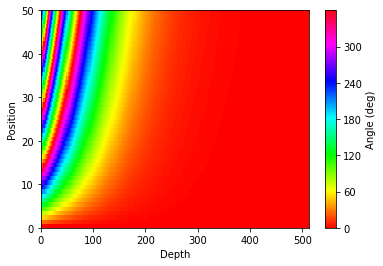

In [10]:
def compute_angles(pos, i, d_model):
  angle = pos / np.power(10000, 2 * (i//2) / d_model)
  return angle

def compute_positional_encoding(pos, d_model):
  positions = np.arange(pos)[:, np.newaxis]
  i = np.arange(d_model)[np.newaxis, :]
  angles = compute_angles(positions, i, d_model)
  encodings = np.zeros(angles.shape)
  encodings[:, 0::2] = np.sin(angles[:, 0::2])
  encodings[:, 1::2] = np.cos(angles[:, 1::2])
  encodings = encodings[np.newaxis, :, :]
  return tf.cast(encodings, dtype = tf.float32), angles

positions_encoding, angles_rad = compute_positional_encoding(50, 512)

plt.pcolormesh(angles_rad * 180 / (2 * np.pi) % 360, cmap='hsv')
plt.xlim([0, angles_rad.shape[1]])
plt.xlabel('Depth')
plt.ylabel('Position')
bar = plt.colorbar(label = 'Angle (deg)')
bar.set_ticks(np.linspace(0, 360, 6 + 1))
plt.show()

## Padding & Lookahead masking

In [11]:
# create a mask that indicates to the positions of the padding tokens (batch_size, 1, 1, seq_len) 
def create_padding_mask(seq):
  mask = tf.cast(tf.math.equal(seq, 0), dtype=tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

# create a mask that indicates which tokens are needed when predicting new token(seq_len, seq_len)
def create_lookahead_mask(size):
  return 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)

##Scaled Dot-Product Attention
$Attention(Q,K,V)=softmax_k(\frac{QK^T}{\sqrt{d_k}})V$

In [81]:
def scaled_dot_product_attention(q, k, v, mask):
  qt = tf.matmul(q, k, transpose_b = True)
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = qt / tf.math.sqrt(dk)
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1)
  output = tf.matmul(attention_weights, v)
  return output, attention_weights

## Multihead-Attention
Multihead attention consists of four parts:

*  linear layers and split into heads
*  scaler dot product attention
*  concatenation of heads
*  final linear layer

In [82]:
class MultiHeadAttention(Layer):
  def __init__(self, d_model, heads_num):
    super(MultiHeadAttention, self).__init__()
    self.d_model = d_model
    self.heads_num = heads_num
    self.depth = self.d_model // self.heads_num

    self.wq = Dense(d_model)
    self.wk = Dense(d_model)
    self.wv = Dense(d_model)

    self.fc = Dense(d_model)
  
  def split_into_heads(self, x, batch_size):
    x = tf.reshape(x, (batch_size, -1, self.heads_num, self.depth))
    return tf.transpose(x, perm = (0, 2, 1, 3))
  
  def call(self, k, v, q, mask):
    batch_size = tf.shape(q)[0]
    q = self.wq(q) # batch_size, seq_len_q, d_model
    k = self.wk(k)
    v = self.wv(v)

    q = self.split_into_heads(q, batch_size) # batch_size, heads_num, seq_len_q, depth
    k = self.split_into_heads(k, batch_size)
    v = self.split_into_heads(v, batch_size)

    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm = (0, 2, 1, 3))
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) 

    return self.fc(concat_attention), attention_weights

## Point-wise feed forward network

In [83]:
def point_wise_feed_forward_network(d_model, ff_units_num):
  return Sequential([
                     Dense(ff_units_num, activation = 'relu'),
                     Dense(d_model)
  ])

## Encoder-Decoder

### Encoder Layer
Each encoder layer consists of 2 sub-layers:

*  Multihead attention(with padding mask)
*  point-wise feed forward network

For each sub-layer:
*  the output is $LayerNorm(x + Sublayer(x))$
*  we implement a residual connection around it followed by a linear normalization

In [84]:
class EncoderLayer(Layer):
  def __init__(self, d_model, heads_num, ff_units_num, dp_rate = 0.1):
    super(EncoderLayer, self).__init__()
    
    self.multihead_attention = MultiHeadAttention(d_model, heads_num)
    self.dropout1 = Dropout(dp_rate)
    self.layer_norm1 = LayerNormalization(epsilon = 1e-6)

    self.feed_forward = point_wise_feed_forward_network(d_model, ff_units_num)
    self.dropout2 = Dropout(dp_rate)
    self.layer_norm2 = LayerNormalization(epsilon = 1e-6)
  
  def call(self, x, is_training, mask):
    attention_output, _ = self.multihead_attention(x, x, x, mask)
    attention_output = self.dropout1(attention_output, training = is_training)
    sub_layer_output = self.layer_norm1(x + attention_output)

    feed_forward_output = self.feed_forward(sub_layer_output)
    feed_forward_output = self.dropout2(feed_forward_output, training = is_training)
    output = self.layer_norm2(sub_layer_output + feed_forward_output)
    return output

###Decoder Layer
Each decoder layer consists of 3 sub-layers:
*  masked Multihead attention sub-layer with lookahead mask and padding mask
*  multihead attention sub-layer with padding mask. it recieves the encoder output and used as key-value, and recieves the decoder first sub-layer's output and use it as a query
*  point wise feed forward network

For each sub-layer:

*  We implement a residual connection around it followed by linear normalization
*  the output is $LayerNorm(x + Sublayer(x))$

The decoder predicts the next word by attending the encoder output and its own output.

In [85]:
class DecoderLayer(Layer):
  def __init__(self, d_model, heads_num, ff_units_num, dp_rate = 0.1):
    super(DecoderLayer, self).__init__()
    self.masked_multihead_attention = MultiHeadAttention(d_model, heads_num)
    self.dropout1 = Dropout(dp_rate)
    self.layer_norm1 = LayerNormalization(epsilon = 1e-6)

    self.multihead_attention = MultiHeadAttention(d_model, heads_num)
    self.dropout2 = Dropout(dp_rate)
    self.layer_norm2 = LayerNormalization(epsilon = 1e-6)

    self.feed_forward = point_wise_feed_forward_network(d_model, ff_units_num)
    self.dropout3 = Dropout(dp_rate)
    self.layer_norm3 = LayerNormalization(epsilon = 1e-6)
  
  def call(self, x, enc_output, is_training, look_ahead_mask, mask):
    mmha_out, self_attention_weights = self.masked_multihead_attention(x, x, x, look_ahead_mask)
    mmha_out = self.dropout1(mmha_out, training = is_training)
    out1 = self.layer_norm1(mmha_out + x)

    mha_out, attention_weights = self.multihead_attention(k = enc_output, v = enc_output, q = out1, mask = mask)
    mha_out = self.dropout2(mha_out, training = is_training)
    out2 = self.layer_norm2(mha_out + out1)

    ff_out = self.feed_forward(out2)
    ff_out = self.dropout3(ff_out, training = is_training)
    out3 = self.layer_norm3(ff_out + out2)
    return out3, self_attention_weights, attention_weights

###Encoder
Ther encoder consists of:
*  embedding layer
*  positional encoder
*  N encoder layers

In [86]:
class Encoder(Layer):
  def __init__(self, layers_num, d_model, heads_num, ff_units_num, vocab_size, max_pos_enc, dp_rate = 0.1):
    super(Encoder, self).__init__()
    self.d_model = d_model
    self.layers_num = layers_num

    self.embeddings = Embedding(vocab_size, d_model)
    self.pos_encodings, _ = compute_positional_encoding(max_pos_enc, d_model)
    self.enc_layers = [EncoderLayer(d_model, heads_num, ff_units_num, dp_rate) for _ in range(layers_num)]
    self.dropout = Dropout(dp_rate)
  
  def call(self, x, is_training, mask):
    seq_len = tf.shape(x)[1]
    x = self.embeddings(x)
    x = x * tf.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encodings[:, :seq_len, :]

    x = self.dropout(x, training = is_training)

    for i in range(self.layers_num):
      x = self.enc_layers[i](x, is_training, mask)
    return x

###Decoder
Ther decoder consists of:

*  embedding layer
*  positional encoder
*  N encoder layers

In [87]:
class Decoder(Layer):
  def __init__(self, layers_num, d_model, heads_num, ff_units_num, vocab_size, max_pos_enc, dp_rate = 0.1):
    super(Decoder, self).__init__()
    self.layers_num = layers_num
    self.d_model = d_model

    self.embeddings = Embedding(vocab_size, d_model)
    self.pos_encodings, _ = compute_positional_encoding(max_pos_enc, d_model)
    self.dec_layers = [DecoderLayer(d_model, heads_num, ff_units_num, dp_rate) for _ in range(layers_num)]
    self.dropout = Dropout(dp_rate)
  
  def call(self, x, enc_output, is_training, lookahead_mask, mask):
    attention_weigths_dic = {}
    seq_len = tf.shape(x)[1]
    x = self.embeddings(x)
    x = x * tf.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encodings[:, :seq_len, :]

    x = self.dropout(x, training = is_training)

    for i in range(self.layers_num):
      x, self_attention_weigths, attention_weigths = self.dec_layers[i](x, enc_output, is_training, lookahead_mask, mask)
      attention_weigths_dic['dec_layer{}_self_attention'.format(i + 1)] = self_attention_weigths
      attention_weigths_dic['dec_layer{}_attention'.format(i + 1)] = attention_weigths
    
    return x, attention_weigths_dic

#Transformer

In [88]:
class Transformer(Model):
  def __init__(self, layers_num, d_model, heads_num, ff_units_num, 
               src_vocab_size, dist_vocab_size,
               src_max_pos_enc, dist_max_pos_enc, dp_rate = 0.1,):
    super(Transformer, self).__init__()
    
    self.encoder = Encoder(layers_num, d_model, heads_num, ff_units_num, src_vocab_size, src_max_pos_enc, dp_rate)
    self.decoder = Decoder(layers_num, d_model, heads_num, ff_units_num, dist_vocab_size, dist_max_pos_enc, dp_rate)
    self.fc = Dense(dist_vocab_size)
  
  def call(self, src_input, dist_input, is_training, src_mask, dist_lah_mask, dist_mask):
    enc_out = self.encoder(src_input, is_training, src_mask)
    dec_out, attention_dict = self.decoder(dist_input, enc_out, is_training, dist_lah_mask, dist_mask)
    output = self.fc(dec_out)
    return output, attention_dict

## Hyperparameters

In [20]:
layers_num = 4 #6
d_model = 128 #512
ff_units_num = 512 #2048
heads_num = 8 #8
dp_rate = 0.1 #0.1

EPOCHS = 20
DIST_MAX_LEN = 40

##Optimizer

We use Adam optimizer with $\beta_1 =0.9, \beta_2=0.98, \epsilon=10^{-9}$ and scheduled learning rate: 

$lr=\frac{1}{\sqrt{d_{model}}}min(\frac{1}{\sqrt{step\_num}}, \frac{step\_num}{\sqrt{warmup\_step^3}})$

According to the equation, learning rate will increase at the begining of the training, then it will decrease.

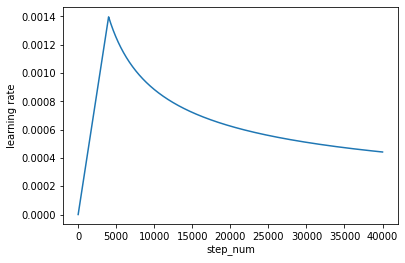

In [21]:
class LearningRateDecaySchedule(LearningRateSchedule):
  def __init__(self, d_model, warmup_steps = 4000):
    super(LearningRateSchedule, self).__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmpu_steps = tf.cast(warmup_steps, dtype=tf.float32)

  def __call__(self, step_num):
    min_term_arg1 = tf.math.rsqrt(step_num)
    min_term_arg2 = step_num * tf.math.rsqrt(tf.math.pow(self.warmpu_steps, 3))
    min_term = tf.math.minimum(min_term_arg1, min_term_arg2)
    lr = tf.math.rsqrt(self.d_model) * min_term
    return lr

temp_lr = LearningRateDecaySchedule(d_model)
steps = tf.range(4*10**4, dtype=tf.float32)
plt.plot(temp_lr(steps))
plt.xlabel('step_num')
plt.ylabel('learning rate')
plt.show()

In [22]:
lr = LearningRateDecaySchedule(d_model)
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Loss and Metrics

In [23]:
loss_objective = SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

def loss_function(y_true, y_hat):
  mask = tf.logical_not(tf.math.equal(y_true, 0))
  loss_ = loss_objective(y_true, y_hat)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

training_loss = Mean(name = 'training_loss')
training_acc = SparseTopKCategoricalAccuracy(name = 'training_acc')

## Training & Checkpoints

In [24]:
!rm -R checkpoints

rm: cannot remove 'checkpoints': No such file or directory


In [25]:
transformer = Transformer(
    layers_num, d_model, heads_num, ff_units_num,
    src_vocabs_size, dist_vocabs_size,
    src_max_pos_enc = src_vocabs_size, dist_max_pos_enc = dist_vocabs_size,
    dp_rate = dp_rate,
)

ckpt_dir = 'checkpoints/training'
ckpt = Checkpoint(transformer = transformer, optimizer = optimizer)
ckpt_manager = CheckpointManager(ckpt, ckpt_dir, max_to_keep = 5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Last training checkpoint is restored!')

In [26]:
def create_masks(src_seqs, dist_seqs):
  enc_padding_mask = create_padding_mask(src_seqs)

  dec_att_padding_mask = create_padding_mask(src_seqs)

  padding_mask = create_padding_mask(dist_seqs)
  lookahead_mask = create_lookahead_mask(tf.shape(dist_seqs)[1])
  dec_lah_mask = tf.maximum(padding_mask, lookahead_mask)

  return enc_padding_mask, dec_lah_mask, dec_att_padding_mask


In [27]:
train_step_signature = [
                        tf.TensorSpec(shape = (None, None), dtype = tf.int64),
                        tf.TensorSpec(shape = (None, None), dtype = tf.int64),
]
@tf.function(input_signature = train_step_signature)
def train_step(src_seqs, dist_seqs):
  dist_seqs_shifted = dist_seqs[:, :-1]
  dist_seqs_real = dist_seqs[:, 1:]

  enc_padding_mask, dec_lah_mask, dec_att_padding_mask = create_masks(src_seqs, dist_seqs_shifted)

  with tf.GradientTape() as tape:
    y_hat, _ = transformer(
        src_seqs, dist_seqs_shifted, 
        True, 
        enc_padding_mask, dec_lah_mask, dec_att_padding_mask,
    )
    loss = loss_function(dist_seqs_real, y_hat)

  variables = transformer.trainable_variables
  grads = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(grads, variables))

  training_loss(loss)
  training_acc(dist_seqs_real, y_hat)


In [28]:
def train_transformer():
  for epoch in range(1, EPOCHS + 1):
    start = time.time()
    training_loss.reset_states()
    training_acc.reset_states()

    for batch, (src_seqs, dist_seqs) in enumerate(dataset):
      train_step(src_seqs, dist_seqs)
      
      if batch % 50 == 0:
        msg = 'Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch, batch, training_loss.result(), training_acc.result(),
        )
        print(msg)

    if epoch % 2 == 0:
      ckpt_save_path = ckpt_manager.save()
      msg = 'Saving checkpoint for epoch {} at {}'.format(
          epoch, ckpt_save_path
      )
      print(msg)
    
    msg = 'Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
            epoch, training_loss.result(), training_acc.result(),
    )
    print(msg)
    msg = 'Time taken for {}th epoch is {:.2f} secs.\n'.format(
        epoch, time.time() - start
    )
    print(msg)

train_transformer()

Epoch 1 Batch 0 Loss 4.3528 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.6297 Accuracy 0.0256
Epoch 1 Batch 100 Loss 4.4063 Accuracy 0.0766
Epoch 1 Batch 150 Loss 4.4149 Accuracy 0.0974
Epoch 1 Loss 4.3881 Accuracy 0.1042
Time taken for 1th epoch is 130.68 secs.

Epoch 2 Batch 0 Loss 4.6322 Accuracy 0.1705
Epoch 2 Batch 50 Loss 4.0808 Accuracy 0.1443
Epoch 2 Batch 100 Loss 4.0900 Accuracy 0.1511
Epoch 2 Batch 150 Loss 3.9399 Accuracy 0.1510
Saving checkpoint for epoch 2 at checkpoints/training/ckpt-1
Epoch 2 Loss 3.8893 Accuracy 0.1508
Time taken for 2th epoch is 114.75 secs.

Epoch 3 Batch 0 Loss 3.1546 Accuracy 0.1406
Epoch 3 Batch 50 Loss 3.4801 Accuracy 0.1644
Epoch 3 Batch 100 Loss 3.3368 Accuracy 0.1593
Epoch 3 Batch 150 Loss 3.2529 Accuracy 0.1578
Epoch 3 Loss 3.2222 Accuracy 0.1582
Time taken for 3th epoch is 116.45 secs.

Epoch 4 Batch 0 Loss 2.6613 Accuracy 0.1462
Epoch 4 Batch 50 Loss 2.9526 Accuracy 0.1663
Epoch 4 Batch 100 Loss 2.9619 Accuracy 0.1694
Epoch 4 Batch 150 Loss 2.86

## Evaluation

In [89]:
def run_transformer_step(enc_input, output):
  enc_padding_mask, dec_lah_mask, dec_att_padding_mask = create_masks(enc_input, output)
  logits, attentions_dict = transformer(enc_input, output, False,
                                          enc_padding_mask, dec_lah_mask, dec_att_padding_mask,
  )
  log_probas = tf.nn.log_softmax(logits, axis=-1)
  return log_probas, attentions_dict

def generate_candidates(enc_input, dec_input, beam_width, score):
  log_probas, attentions_dict = run_transformer_step(enc_input, dec_input)
  scores, candidates = tf.nn.top_k(log_probas[0,-1, :], sorted = True, k = beam_width)
  scores += score
  return candidates, attentions_dict, scores

def candidates2seqs(dec_input, candidates, scores):
  seqs = []
  for candidate, score in zip(candidates, scores):
    tmp_dec_input = tf.concat([dec_input, tf.expand_dims([candidate], 0)], axis = -1)
    seqs.append([tmp_dec_input, score])
  return seqs

all_seqs = []
def generate_child_seqs(enc_input, dec_input, beam_width, score):
  candidates, attentions_dict, scores = generate_candidates(enc_input, dec_input, beam_width, score)
  seqs = candidates2seqs(dec_input, candidates, scores)
  for seq, score in seqs:
    if seq[0, -1] ==  dist_tokenizer.vocab_size + 1:
      all_seqs.append((seq, score))
      return True
    generate_child_seqs(enc_input, seq, beam_width, score)


def beam_search(enc_input, dec_input, beam_width):
  candidates, attentions_dict, scores = generate_candidates(enc_input, dec_input, beam_width, 0)
  seqs = candidates2seqs(dec_input, candidates, scores)
  for seq, score in seqs:
    new_seqs = generate_child_seqs(enc_input, seq, beam_width, score)

  seq = sorted(all_seqs, key = lambda tup: tup[1], reverse = True)
  return seq[0][0], None

def predict_beam_search(src_sentence, beam_width = 3,):
  src_start_token = [src_tokenizer.vocab_size]
  src_end_token = [src_tokenizer.vocab_size + 1]

  dist_end = dist_tokenizer.vocab_size + 1
  enc_input = src_start_token + src_tokenizer.encode(src_sentence) + src_end_token
  enc_input = tf.expand_dims(enc_input, 0)

  dec_input = [dist_tokenizer.vocab_size]
  dec_input = tf.expand_dims(dec_input, 0)

  seq, None = beam_search(enc_input, dec_input, beam_width)
  return  tf.squeeze(seq, axis = 0), None

In [75]:
def predict(src_sentence):
  src_start_token = [src_tokenizer.vocab_size]
  src_end_token = [src_tokenizer.vocab_size + 1]

  dist_end = dist_tokenizer.vocab_size + 1
  enc_input = src_start_token + src_tokenizer.encode(src_sentence) + src_end_token
  enc_input = tf.expand_dims(enc_input, 0)

  decoder_input = [dist_tokenizer.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(DIST_MAX_LEN):
    enc_padding_mask, dec_lah_mask, dec_att_padding_mask = create_masks(enc_input, output)
    y_hat, attention_weights_dict = transformer(enc_input, output, 
                                                False,
                                                enc_padding_mask, dec_lah_mask, dec_att_padding_mask,
                                                )
    y_hat = y_hat[:, -1:, :] #(batch_size, seq_len, vocab_size) select the last word
    predict_id = tf.cast(tf.argmax(y_hat, axis = -1), tf.int32)
    
    if predict_id == dist_end:
      return tf.squeeze(output, axis = 0), attention_weights_dict
    output = tf.concat([output, predict_id], axis = -1)

  return tf.squeeze(output, axis = 0), attention_weights_dict

def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  sentence = src_tokenizer.encode(sentence)
  attention = tf.squeeze(attention[layer], axis = 0)
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head + 1)
    ax.matshow(attention[head][:-1, :], cmap='viridis')
    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence) + 2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result) - 1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>'] + [src_tokenizer.decode([i]) for i in sentence] + ['<end>'], 
        fontdict = fontdict, rotation = 90
    )
    
    ax.set_yticklabels(
        [dist_tokenizer.decode([i]) for i in result if i < dist_tokenizer.vocab_size], 
        fontdict = fontdict,
    )
    
    ax.set_xlabel('Head {}'.format(head + 1))
  
  plt.tight_layout()
  plt.show()

def translate(src_sentence, use_beam = False, plot = ''):
  src_pre_sentence = process_sentence(src_sentence, lang = 'en')
  output, attention_weights_dict = None, None
  if use_beam:
    output, attention_weights_dict = predict_beam_search(src_pre_sentence)
  else:
    output, attention_weights_dict = predict(src_pre_sentence)

  result = [i for i in output if i < dist_tokenizer.vocab_size]
  translated_sentence = dist_tokenizer.decode(result)

  print('Input:\t\t', src_pre_sentence)
  print('Translation:\t', translated_sentence)

  if plot:
    plot_attention_weights(attention_weights_dict, src_pre_sentence, output, plot)

In [70]:
for sent in sents2trans:
  translate(sent)
  print()

Input:		 how to run a car?
Translation:	 كيف حال سيارتك

Input:		 what kind of food do you like?
Translation:	 أي نوع من الفواكه تريد

Input:		 he comes from syria.
Translation:	 ذهب من الهند.

Input:		 he has a lot of money.
Translation:	 إنه كثير من المال.

Input:		 it is good.
Translation:	 إنها تمطر.

Input:		 do you have friends?
Translation:	 هل عندك أصدقاء

Input:		 it is a nice weather.
Translation:	 إنها صغيرة جدا.

Input:		 they are very bad people.
Translation:	 هم كبار جدا

Input:		 do you need help?
Translation:	 هل تريد أن تأتي إلى رأيك



In [77]:
for sent in sents2trans:
  all_seqs = []
  translate(sent, use_beam = True)
  print()

Input:		 how to run a car?
Translation:	 كيف حال سيارتك

Input:		 what kind of food do you like?
Translation:	 أي نوع من الفواكه تريد

Input:		 he comes from syria.
Translation:	 ذهب توم.

Input:		 he has a lot of money.
Translation:	 عنده الكثير من المال.

Input:		 it is good.
Translation:	 إنها تمطر.

Input:		 do you have friends?
Translation:	 هل عندك أصدقاء

Input:		 it is a nice weather.
Translation:	 إنها صغيرة جدا.

Input:		 they are very bad people.
Translation:	 هم كبار جدا

Input:		 do you need help?
Translation:	 هل تريد أن آتي



Input:		 i came on foot.
Translation:	 أتيت سيرا .


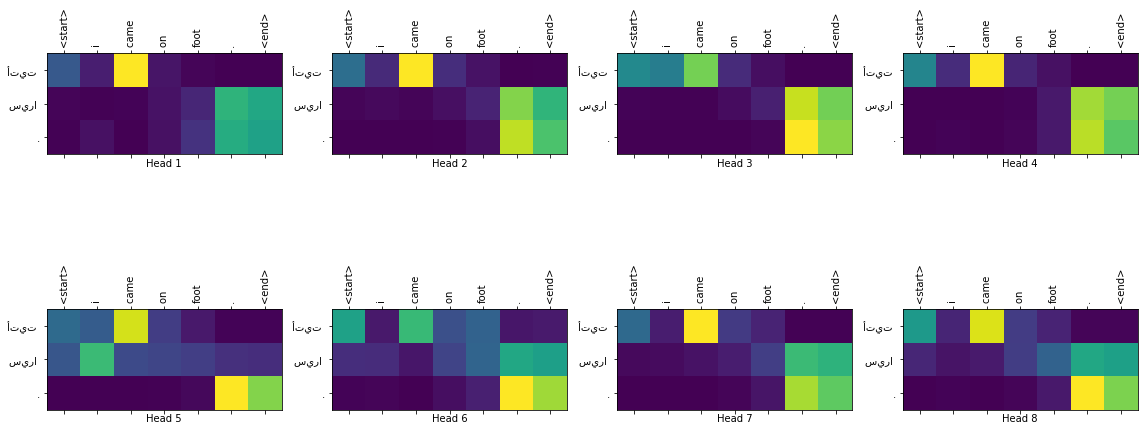

In [79]:
ind = np.random.randint(len(src_sentences))
sent2trans = src_sentences[ind]
translate(sent2trans, False, 'dec_layer4_attention')

Input:		 he has a lot of money.
Translation:	 إنه كثير من المال.


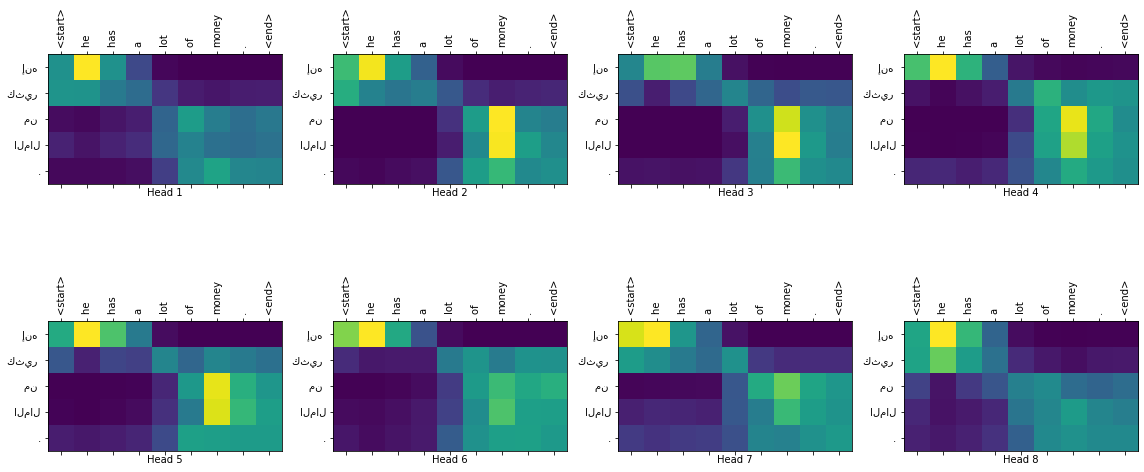

In [80]:
translate('he has a lot of money.', False, 'dec_layer4_attention')